# Time Series Prediction


In [1]:
# @ Lukman copyright 
# MIT Licence

In [1]:
# for data frame analysis
import pandas as pd 

# for mathematical operations
import numpy as np 


# matplotlib library for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Normalizing data
from sklearn.preprocessing import StandardScaler

# For statistical test
import scipy.stats as stats

# Split data set into training and test set
from sklearn.model_selection import train_test_split as tts

# SVN module
from sklearn import svm

# Kernel Functions used 
from sklearn.metrics.pairwise import rbf_kernel,laplacian_kernel

# module for chi square test
from scipy.stats import chisquare


# For dictionary 
from collections import defaultdict

# for use of tensorflow
import tensorflow as tf
tf.enable_eager_execution()

#from tensorflow.nn.rnn import *
from tensorflow.python.ops  import *

# for scaling arrays
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler


# for random sampling of validation set
import random

import yaml
import os
from utility import utils

%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [5]:
# enable eager executinon
tf.enable_eager_execution()

In [6]:
tf.__version__

'1.15.0'

# Data Preprocessing 

In [26]:
################################################################################
# load config file
try:
    with open("../config.yml", 'r') as ymlfile:
            cfg = yaml.safe_load(ymlfile)
except (IOError):
    print('config file is required. Put config file in current directory')
################################################################################

In [7]:
# current working directory
cwd = os.getcwd()
# set the base directory. base directo
BASE_DIR = os.path.join( os.path.dirname( cwd), '' )
# cleaned data dir
cleanedpath= BASE_DIR + cfg['cleanedconfig']['cleanedDataV1']['cleanedDir'] 
# clean data Name
cleandataName = cfg['cleanedconfig']['cleanedDataV1']['cleanedName']
# traina and validation data name
trainName= cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfcleanTrain']
validateName  = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfcleanValidate']
validation_split = cfg['cleanedconfig']['cleanedDataV1']['validationSplit']

In [8]:
# boolean for preprocessing datasets for tensorflow
tfreprocess = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfprocess']

In [9]:
if tfreprocess:
    
    _,_,data_types,col_names= utils.tfdatabuilder(cleanedpath,cleandataName,trainName, validateName,validation_split )
    
else:
    
    train = pd.read_csv(cleanedpath + trainName) 
    data_types,col_names = utils.tfpreprocess(train)

#### Work with downloaded csv to preserve data type
Load the csv file and parse the data types of the datatset together into the
tensorflow load pipeline

In [11]:
# load the data using the tensorflow Dataset API
# add the data types too
csvData = tf.data.experimental.CsvDataset(cleanedpath + trainName, data_types, header=True)

In [13]:
# categorical features to use 
catfeatures = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['categoricalFeatureToUse']
catNames = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['CategoricalFeature']

#### Parse data 

In [14]:
# Parsing the data and
# merging the columns:
# ---- day and month as single column
# ---- merge the site id as a single feature vector vector
# ---- primary use as a single feature vector

# take the forst 4 col names that meter reading, square feet, air temp , dew temp,
# add it to a the new column names that would be formed after single column merging

#categorical feature selection
# here one can decide if to use site id or not . Site id is index 2 from catnames
if catfeatures == 3:
    col_names_= [col_names[0],col_names[1],col_names[2],col_names[3],catNames[0],catNames[1],catNames[2] ]
else:
    col_names_= [col_names[0],col_names[1],col_names[2],col_names[3],catNames[0],catNames[1]]

def _parse_csv_row(*vals):
    '''
    Uses Feature columns
    Does feature engineering
    '''
    
    # month and day and single feature
    month_day = tf.convert_to_tensor(vals[4:7])
    # primary use as single feature
    primary_use = tf.convert_to_tensor(vals[7:21]) # this index can be chage but ensure consistency 
    if catfeatures == 3:
        # site id as single feature
        site_id =  tf.convert_to_tensor(vals[21:31])
    
        # merge the features together, note meter reading is the fist column
        # so it is excluded -- meaning index starts from 1
        feature_vals = vals[1:4] + (month_day,primary_use,site_id)
    else:
        feature_vals = vals[1:4] + (month_day,primary_use)
        
    
    
    # zip into a  feature sets into a single col
    features = dict(zip(col_names_[1:],feature_vals))
    
    # name the targets or lables
    targets_tensor = tf.convert_to_tensor(vals[0],name=col_names_[0]) 
    
    
    
    return features, targets_tensor

##### Batch the datatset

In [15]:
# this is needed for testing
dataset = csvData.map(_parse_csv_row).batch(64)

##### Feature Categorization

In [16]:
primary_use = tf.feature_column.numeric_column(catNames[1], shape=(14,))
site_id = tf.feature_column.numeric_column(catNames[2], shape=(10,))
month_day = tf.feature_column.numeric_column(catNames[0], shape=(3,))

In [17]:
#
numeric_columns = [tf.feature_column.numeric_column(feat) for feat in col_names_[1:4]]

In [18]:
#columns = numeric_columns + [month_day,primary_use,site_id]

In [19]:
#feature_layer = tf.keras.layers.DenseFeatures(columns)

In [20]:
# function to serve the data set 
def load_data(*filename,fn = _parse_csv_row,training=True):
    Training = training
    batchsize = 64
    csvData = tf.data.experimental.CsvDataset(filename, data_types, header=True)
    dataset= csvData.map(fn)
    if Training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batchsize)
    
    

# Build Model

In [21]:
from tensorflow.keras import backend as K

def root_mean_squared_error():
    '''
    
    this is the loss function specified in kaggle competition
    '''
        
    return K.sqrt(K.mean (K.square( (K.log(K.abs(y_pred)+1) - K.log(y_true+1))   )   )   )



def root_mean_squared_error2():
    '''
    this is 1.- mean squared
    root mean squared is a value between 0 and 1 
    to reflect accuracy use 1-rms
    '''
        
    return  K.sqrt(K.mean( ( K.square ( y_pred - y_true    )   )   )) 

In [22]:
# wide and deep model 
# https://arxiv.org/pdf/1606.07792.pdf
model = tf.estimator.DNNLinearCombinedRegressor(
          # wide settings
         linear_feature_columns=[month_day, primary_use,site_id ],
         linear_optimizer=tf.train.FtrlOptimizer(1e-6,l2_regularization_strength=1e-8 ),
         # deep settings
         dnn_feature_columns=[
           primary_use, site_id,
           numeric_columns[0],numeric_columns[1],numeric_columns[2]],
        dnn_hidden_units=[600, 300, 100],
        dnn_dropout=0.3,
        dnn_optimizer=tf.train.ProximalAdagradOptimizer(1e-6,l2_regularization_strength=1e-10)
      )


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp34kzyhfe', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc7a3517650>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [23]:
# add the metrics to use in the computation
model = tf.contrib.estimator.add_metrics(model, root_mean_squared_error)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp34kzyhfe', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_

In [24]:
# run training

for i in range(3):
    model.train(input_fn=lambda : load_data(cleanedpath + trainName), steps=100)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp34kzyhfe/model.ckpt.


InvalidArgumentError: Field 0 in record is not a valid double: meter_reading
	 [[node IteratorGetNext (defined at /home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]

Original stack trace for 'IteratorGetNext':
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-4aed6032ce58>", line 4, in <module>
    model.train(input_fn=lambda : load_data(cleanedpath + trainName), steps=100)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 370, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1161, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1188, in _train_model_default
    input_fn, ModeKeys.TRAIN))
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1025, in _get_features_and_labels_from_input_fn
    self._call_input_fn(input_fn, mode))
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/util.py", line 65, in parse_input_fn_result
    result = iterator.get_next()
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 426, in get_next
    name=name)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 2518, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


## Testing
please skip testing

In [63]:
def _parse_csv_row2(*vals):
    '''
    Uses Feature columns
    Does feature engineering
    '''
    
    # month and day and single feature
    month_day = tf.convert_to_tensor(vals[4:7])
    # primary use as single feature
    primary_use = tf.convert_to_tensor(vals[7:21])
    # site id as single feature
    site_id =  tf.convert_to_tensor(vals[21:30])
    
    # merge the features together, note meter reading is the fist column
    # so it is excluded -- meaning index starts from 1
    feature_vals = vals[1:4] + (month_day,primary_use,site_id)
    
    
    # zip into a  feature sets into a single col
    features = dict(zip(col_names_[1:],feature_vals))
    
    # name the targets or lables
    targets_tensor = tf.convert_to_tensor(vals[0],name=col_names_[0]) 
    
    
    
    return features

In [64]:
# function to serve the data set 
def load_data2(*filename,fn = _parse_csv_row2):
    batchsize = 64
    csvData = tf.data.experimental.CsvDataset(filename, data_types, header=False)
    dataset= csvData.map(fn)
    return dataset.batch(batchsize)
    
    

In [65]:
    #model.train(input_fn=lambda : load_data('meter1.csv'), steps=100)

In [66]:
predictions = model.predict(input_fn=lambda : load_data2('meter1Test.csv'))

In [67]:
results   = list(predictions);
#tf.logging.info(results)
#results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpuolvdryl/model.ckpt-700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [68]:
# get predicted values from list
pred = []
for i in results:
    pred.append( i['predictions'])



In [69]:
# get true values
true_values=pd.read_csv('meter1Test.csv',header=None)[0].values

Text(0.5, 0, 'Iterations')

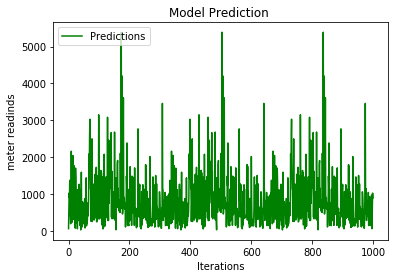

In [70]:
plt.plot(pred,"-g" ,label='Predictions')
#plt.plot(true_values, "-r",label='True Values')
plt.legend(loc="upper left")
plt.title('Model Prediction ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

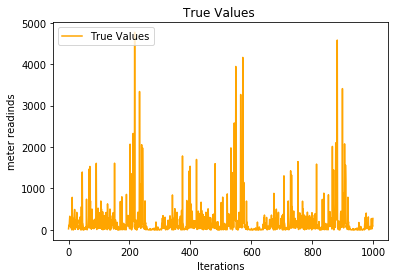

In [195]:
#plt.plot(predictions,"-g" ,label='Predictions')
plt.plot(true_values, "-r",label='True Values',color='orange')
plt.legend(loc="upper left")
plt.title('True Values ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

#### Plot per Building

In [71]:
from utility import utils
%load_ext autoreload
%autoreload 2

In [72]:
test_predicted = pd.DataFrame(list(zip(test_building_id,test_timestamp,pred)),columns= ['building_id','timestamp', 'meter_reading' ,] )

In [73]:
true_readings = pd.DataFrame(list(zip(test_building_id,test_timestamp,list(true_values))),columns= ['building_id','timestamp', 'meter_reading' ,] )

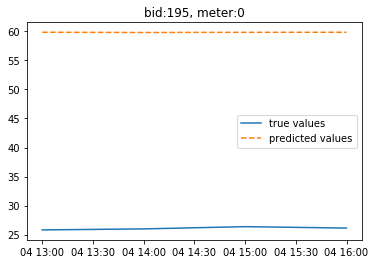

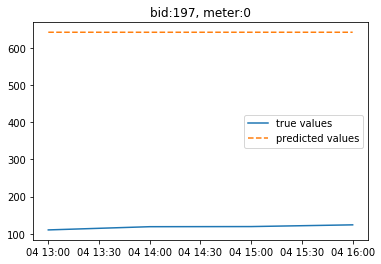

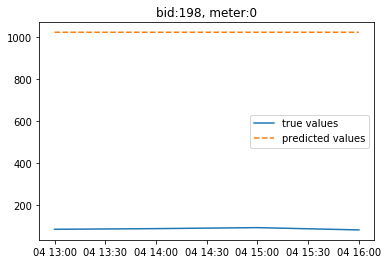

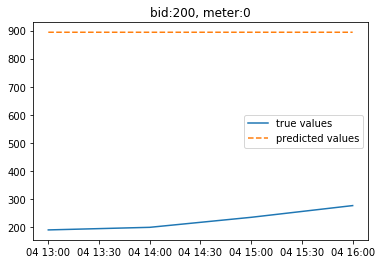

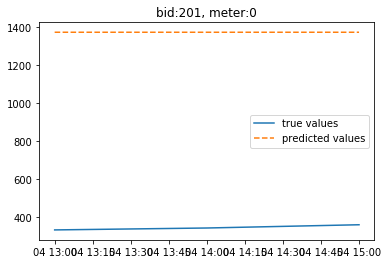

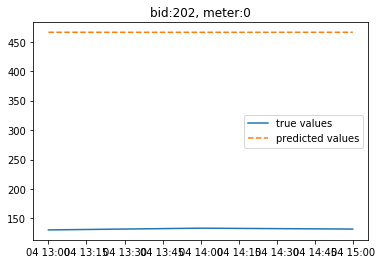

In [75]:
utils.plot_meter(true_readings,test_predicted,n_plots=5)

# save model

In [27]:
checkpoint_path = cfg['savedModel']['myname']['Dir3']

In [28]:
featuresample = list(dataset.take(1))[0][0]

In [29]:
# input function
inut_receive_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(featuresample)

In [30]:
model.export_saved_model(export_dir_base=checkpoint_path ,serving_input_receiver_fn=inut_receive_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:
INFO:tensorflow:'serving_default' : Regression input must be a single string Tensor; got {'square_feet': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=int32>, 'air_temperature': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype

b'savedModels/CombinedLinear/1579537992'